In [1]:
import sys
sys.path.insert(0, '..')

import PipelineTS
PipelineTS.__version__

'0.3.11'

In [11]:
import numpy as np

class Quantizer:
    def __init__(self, data):
        self.data = data
        self.min_vals = np.min(data, axis=0)
        self.max_vals = np.max(data, axis=0)

    def quantize_multiple(self):
        n_vectors = len(self.data)
        n_levels = 2 ** 8  # uint8的最大值加1
        scales = (self.max_vals - self.min_vals) / n_levels
        quantized = np.zeros((n_vectors,), dtype=np.uint8)

        for i in range(n_vectors):
            quantized[i] = np.round((self.data[i] - self.min_vals[i]) / scales[i])

        return quantized, scales

    def dequantize_multiple(self, quantized_data, scales):
        n_vectors = len(quantized_data)
        dequantized = np.zeros((n_vectors,), dtype=np.float32)

        for i in range(n_vectors):
            dequantized[i] = quantized_data[i] * scales[i] + self.min_vals[i]

        return dequantized

# 示例用法
data = np.array([[0, 127, 255], [50, 100, 200]], dtype=np.uint8)
quantizer = Quantizer(data)
quantized_data, scales = quantizer.quantize_multiple()
print("Quantized data:", quantized_data)
print("Scales:", scales)
dequantized_data = quantizer.dequantize_multiple(quantized_data, scales)
print("Dequantized data:", dequantized_data)


ValueError: setting an array element with a sequence.

# Quickly test all available models using the ModelPipeline class

PipelineTS comes with a variety of built-in industrial datasets that can be directly loaded and utilized through the API.

In [2]:
# import pandas as pd

# from PipelineTS.dataset import LoadMessagesSentDataSets
# from PipelineTS.plot import plot_data_period, plot_single_series

# # load data
# init_data = LoadMessagesSentDataSets()
# print("data_name:", init_data.name, 
#       "\ntime_col:", init_data.time_col, 
#       "\ntarget_col:", init_data.target_col, 
#       "\nfeature_cols:", init_data.feature_cols,
#       "\ndata shape:", init_data.shape)

# time_col = init_data.time_col
# target_col = init_data.target_col

# init_data = init_data[[time_col, target_col]]
# # note that: when using PipelineTS for time series prediction,
# #  it is necessary to convert the time feature column to the pandas datetime64[ns] format in advance
# init_data[time_col] = pd.to_datetime(init_data[time_col])

In [3]:
import pandas as pd
from PipelineTS.plot import plot_data_period, plot_single_series

init_data = pd.read_csv('/Users/guobingming/Downloads/dau.csv', sep=',', encoding='utf-8')
init_data = init_data.iloc[:-1, :]

time_col = 'dt'
target_col = 'dau'
init_data[time_col] = pd.to_datetime(init_data[time_col])
init_data[target_col] = init_data[target_col].str.replace('\ufeff', '', regex=False)
init_data[target_col] = init_data[target_col].astype(int)
init_data.fillna(-1, inplace=True)
init_data.head()

,dau,active_retention_users,active_retention,long_vod_play_uv,long_vod_play_uv_rate,long_vod_play_dau_ret,long_vod_play_dau_ret_rate,long_vod_play_ret,long_vod_play_ret_rate,long_vod_player_duration,...,variety_1_play_uv_rate,variety_1_play_uv_dau_rate,variety_1_play_dau_ret_rate,variety_1_play_ret_rate,short_collection_vod_play_uv,short_collection_vod_player_duration_avg,short_collection_vod_play_uv_rate,short_collection_vod_play_dau_ret_rate,short_collection_vod_play_ret_rate,dt
0,170020,101663.0,0.597947,67130.0,0.394836,46274.0,0.689319,40453.0,0.602607,0.0,...,0.000000,0.000000,0.000000,0.000000,33480.0,0.0,0.196918,0.608423,0.483572,2019-12-31
1,173139,104856.0,0.605617,70585.0,0.407678,48864.0,0.692272,42778.0,0.606049,0.0,...,0.053680,0.021884,0.603061,0.297968,65852.0,0.0,0.380342,0.614120,0.458938,2020-01-01
2,175640,110937.0,0.631616,72146.0,0.410761,52266.0,0.724448,46983.0,0.651221,0.0,...,0.056122,0.023053,0.636206,0.301062,63189.0,0.0,0.359764,0.648910,0.433920,2020-01-02
3,175917,107813.0,0.612863,78567.0,0.446614,53024.0,0.674889,45542.0,0.579658,0.0,...,0.043173,0.019282,0.625000,0.343160,53056.0,0.0,0.301597,0.640191,0.510706,2020-01-03
4,178162,106775.0,0.599314,72420.0,0.406484,50176.0,0.692847,44672.0,0.616846,0.0,...,0.049738,0.020218,0.616880,0.333426,68048.0,0.0,0.381945,0.614919,0.451020,2020-01-04


## Plotting data

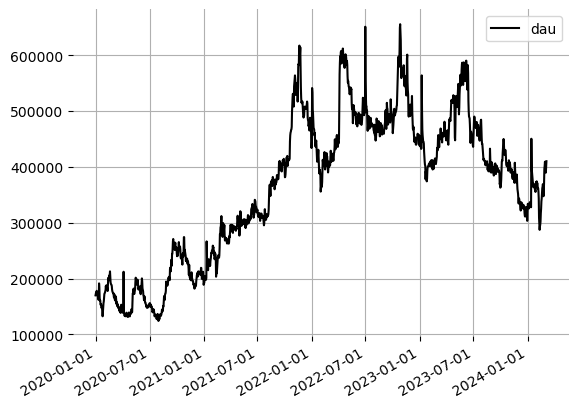

In [4]:
# docs for plot_single_series func
# Visualize time-series data.

# Parameters
# ----------
# series : pd.DataFrame
#     The dataset containing time-series data for plotting.
# time_col : str
#     Column name in the dataframes representing the time information.
# target_col : str
#     Column name in the dataframes representing the target variable.
# label : None or str, optional, default: None
#     Label for the plot. If None, default label 'Data' will be used.
# date_fmt : str, optional, default: '%Y-%m-%d'
#     Date format for the x-axis labels.

plot_single_series(init_data, time_col=time_col, target_col=target_col, label=target_col)

## list all available models

In [5]:
# dividing the training set and the validation set
valid_data = init_data.iloc[-30:, :]
data = init_data.iloc[:-30, :]

# set the computing device, which will specify the computing device for the neural network model
# default to 'auto'
accelerator = 'auto'  

# set the step size for prediction
n = 30

from PipelineTS.pipeline import ModelPipeline

# list all available models
ModelPipeline.list_all_available_models()

['auto_arima',
 'catboost',
 'd_linear',
 'gau',
 'lightgbm',
 'multi_output_model',
 'multi_step_model',
 'n_beats',
 'n_hits',
 'n_linear',
 'patch_rnn',
 'prophet',
 'random_forest',
 'regressor_chain',
 'stacking_rnn',
 'tcn',
 'tft',
 'tide',
 'time2vec',
 'transformer',
 'wide_gbrt',
 'xgboost']

## Training

In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import QuantileTransformer

# Instantiate the ModelPipeline class. 
# If you haven't decided which model to use, you can directly use the ModelPipeline to test the prediction performance of available models in bulk.
# In fact, it is recommended that advanced users directly use the ModelPipeline to use the model, 
#   as the class has built-in feature preprocessing and developer's practical experience rules.

pipeline = ModelPipeline(
    time_col=time_col,  # The time column in the dataset must have a unique column name, and there can only be one time column in the dataset.
    target_col=target_col,  # Prediction target column in the dataset
    
    # This indicates the window size used when selecting historical data for model prediction. 
    # Generally, a longer window can provide the model with more historical information, 
    #   but this depends on whether the data has strong autocorrelation.
    lags=20,  
    # random seed
    random_state=42,
    quantile=None,
    # it can be one of the strings ‘light’, ‘all’, ‘nn’, or ‘ml’, or it is of type None or a list. Default to 'light'
    # It specifies which models are used for prediction, and the names include the following models:
    #   'light' for ['d_linear', 'lightgbm', 'multi_step_model', 'n_hits', 'n_linear', 'random_forest', 'regressor_chain', 'tcn', 'xgboost']
    #   'all' for the list of ModelPipeline.list_all_available_models()
    #   'nn' for ['d_linear', 'gau', 'n_beats', 'n_hits', 'n_linear', 'tcn', 'tft', 'patch_rnn', 'stacking_rnn', 'tide', 'time2vec', 'transformer']
    #   'ml' for ['catboost', 'lightgbm', 'multi_output_model', 'multi_step_model','random_forest', 'regressor_chain', 'wide_gbrt', 'xgboost']
    include_models=['stacking_rnn','patch_rnn'],
    # Specify the performance evaluation criteria when training the model with the pipeline. The default is mean absolute error.
    metric=mean_absolute_error,
    # Is it better to have a lower performance evaluation standard
    metric_less_is_better=True,
    # set the computing device, which will specify the computing device for the neural network model
    accelerator=accelerator,
    # bool or None or transformer that has the type of sklearn.base.TransformerMixin, optional, default: True
    # Use scaler for data scaling, True for MinMaxScaler, None means no scaling.
    # Alternatively, you can specify your own transformer.
    scaler=True
)

# Train all specified models.
pipeline.fit(data, valid_data=valid_data)

2024-03-08 18:12:26 - PipelineTS - INFO - Information about the device used for computation:
MPS  available: True   | MPS  use: True
CUDA available: False  | CUDA use: False
TPU  available: False  | TPU  use: False
CPU  available: True   | CPU  use: False


2024-03-08 18:12:27 - PipelineTS - INFO - There are a total of 2 models to be trained.
2024-03-08 18:12:27 - PipelineTS - INFO - [model 0] fitting and evaluating patch_rnn...
2024-03-08 18:13:08 - PipelineTS - INFO - [model 1] fitting and evaluating stacking_rnn...


Leaderboard,model,train_cost(s),eval_cost(s),metric
0,patch_rnn,31.713524,3.667464,30224.713720
1,stacking_rnn,9.199945,3.261392,58273.343868


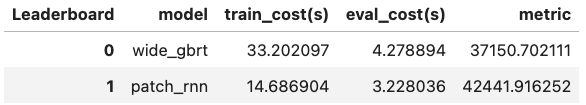

In [51]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import QuantileTransformer

from xgboost import XGBRegressor

# Instantiate the ModelPipeline class. 
# If you haven't decided which model to use, you can directly use the ModelPipeline to test the prediction performance of available models in bulk.
# In fact, it is recommended that advanced users directly use the ModelPipeline to use the model, 
#   as the class has built-in feature preprocessing and developer's practical experience rules.

pipeline = ModelPipeline(
    time_col=time_col,  # The time column in the dataset must have a unique column name, and there can only be one time column in the dataset.
    target_col=target_col,  # Prediction target column in the dataset
    
    # This indicates the window size used when selecting historical data for model prediction. 
    # Generally, a longer window can provide the model with more historical information, 
    #   but this depends on whether the data has strong autocorrelation.
    lags=30,  
    # random seed
    random_state=42,
    
    # it can be one of the strings ‘light’, ‘all’, ‘nn’, or ‘ml’, or it is of type None or a list. Default to 'light'
    # It specifies which models are used for prediction, and the names include the following models:
    #   'light' for ['d_linear', 'lightgbm', 'multi_step_model', 'n_hits', 'n_linear', 'random_forest', 'regressor_chain', 'tcn', 'xgboost']
    #   'all' for the list of ModelPipeline.list_all_available_models()
    #   'nn' for ['d_linear', 'gau', 'n_beats', 'n_hits', 'n_linear', 'tcn', 'tft', 'patch_rnn', 'stacking_rnn', 'tide', 'time2vec', 'transformer']
    #   'ml' for ['catboost', 'lightgbm', 'multi_output_model', 'multi_step_model','random_forest', 'regressor_chain', 'wide_gbrt', 'xgboost']
    include_models='wide_gbrt',
    # Specify the performance evaluation criteria when training the model with the pipeline. The default is mean absolute error.
    metric=mean_absolute_error,
    # Is it better to have a lower performance evaluation standard
    metric_less_is_better=True,
    # set the computing device, which will specify the computing device for the neural network model
    accelerator=accelerator,
    # bool or None or transformer that has the type of sklearn.base.TransformerMixin, optional, default: True
    # Use scaler for data scaling, True for MinMaxScaler, None means no scaling.
    # Alternatively, you can specify your own transformer.
    scaler=True,
    wide_gbrt__estimator=XGBRegressor,
    wide_gbrt__verbose=0
)

# Train all specified models.
pipeline.fit(data)

2024-03-06 17:43:50 - PipelineTS - INFO - Information about the device used for computation:
MPS  available: True   | MPS  use: True
CUDA available: False  | CUDA use: False
TPU  available: False  | TPU  use: False
CPU  available: True   | CPU  use: False


2024-03-06 17:43:51 - PipelineTS - INFO - There are a total of 1 models to be trained.
2024-03-06 17:43:51 - PipelineTS - INFO - [model 0] fitting and evaluating wide_gbrt...


Leaderboard,model,train_cost(s),eval_cost(s),metric
0,wide_gbrt,38.816979,8.008113,32671.834964


## Plotting the forecast results

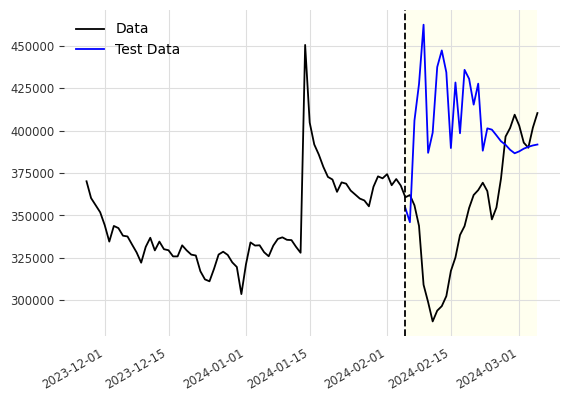

In [16]:
# use best model to predict next 30 steps data point
# You can use `model_name` to specify the pre-trained model in the pipeline when using Python.
prediction = pipeline.predict(30, model_name='stacking_rnn')

plot_data_period(init_data.iloc[-100:, :], prediction, 
                 time_col=time_col, target_col=target_col)

## Make predictions from the last timestamp of the specific sequence  

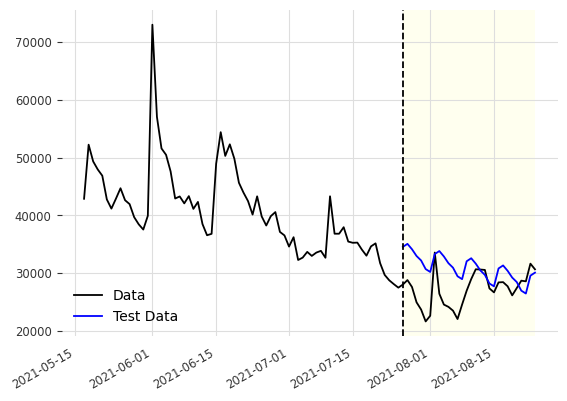

In [7]:
# use best model to predict next 30 steps data point
# You can use `model_name` to specify the pre-trained model in the pipeline when using Python.
prediction = pipeline.predict(n, data=init_data.iloc[-120:-90, :])  

plot_data_period(init_data.iloc[-100:, :], prediction, 
                 time_col=time_col, target_col=target_col)

## ModelPipeline saving and loading

In [8]:
from PipelineTS.io import load_model, save_model

# save
save_model(path='pipeline.zip', model=pipeline)
# load
pipeline = load_model('pipeline.zip')

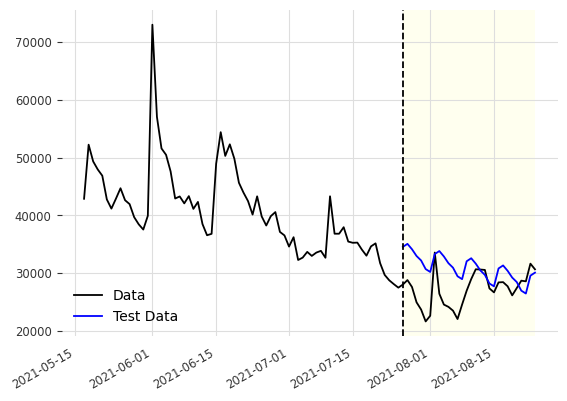

In [9]:
prediction = pipeline.predict(n, data=init_data.iloc[-90:-60, :])   

plot_data_period(init_data.iloc[-100:, :], prediction, 
                 time_col=time_col, target_col=target_col)

# Fit Data with a Single Estimator in the ModelPipeline Class

In [10]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import QuantileTransformer
from PipelineTS.nn_model import StackingRNNModel
from PipelineTS.pipeline import ModelPipeline

pipeline = ModelPipeline(
    time_col=time_col, 
    target_col=target_col, 
    lags=30,  
    random_state=42,
    # Specify the performance evaluation criteria when training the model with the pipeline. The default is mean absolute error.
    metric=mean_absolute_error,
    # Is it better to have a lower performance evaluation standard
    metric_less_is_better=True,
    # set the computing device, which will specify the computing device for the neural network model
    accelerator=accelerator,
    
    # False for MinMaxScaler, True for QuantileTransformer, None means no data be scaled
    scaler=False,

    # include_models : {'light', 'all', 'nn', 'ml'} or list or None or a available model of PipelineTS, optional, default: 'light'
    #   Models to include in the pipeline.
    include_models=StackingRNNModel,
    StackingRNNModel__dropout=0.2
)

# Train all specified models.
pipeline.fit(data, valid_data=valid_data)

MPS  available: True   | MPS  use: True
CUDA available: False  | CUDA use: False
TPU  available: False  | TPU  use: False
CPU  available: True   | CPU  use: False

15:48:14 2023-11-24 - PipelineTS - There are a total of 1 models to be trained.
15:48:14 2023-11-24 - PipelineTS - [model 0] fitting and evaluating StackingRNNModel...


Leaderboard,model,train_cost(s),eval_cost(s),metric
0,StackingRNNModel,15.009838,0.009708,6440.094448


# Fit data with a Single Model

In [11]:
from PipelineTS.nn_model import DLinearModel

In [12]:
model = DLinearModel(time_col, target_col, lags=16, quantile=0.9, random_state=42)

In [13]:
model.fit(data, valid_data=valid_data)

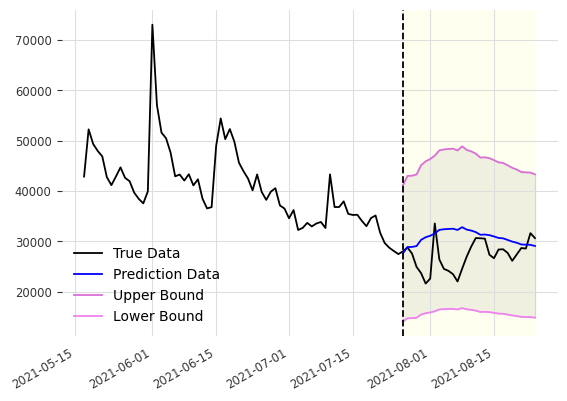

In [14]:
# evaluate 
prediction = model.predict(30)  

plot_data_period(init_data.iloc[-100:, :], prediction, 
                 time_col=time_col, target_col=target_col)